<font size=4>
Author of Question: Ahmad Salimi
			<br/>

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

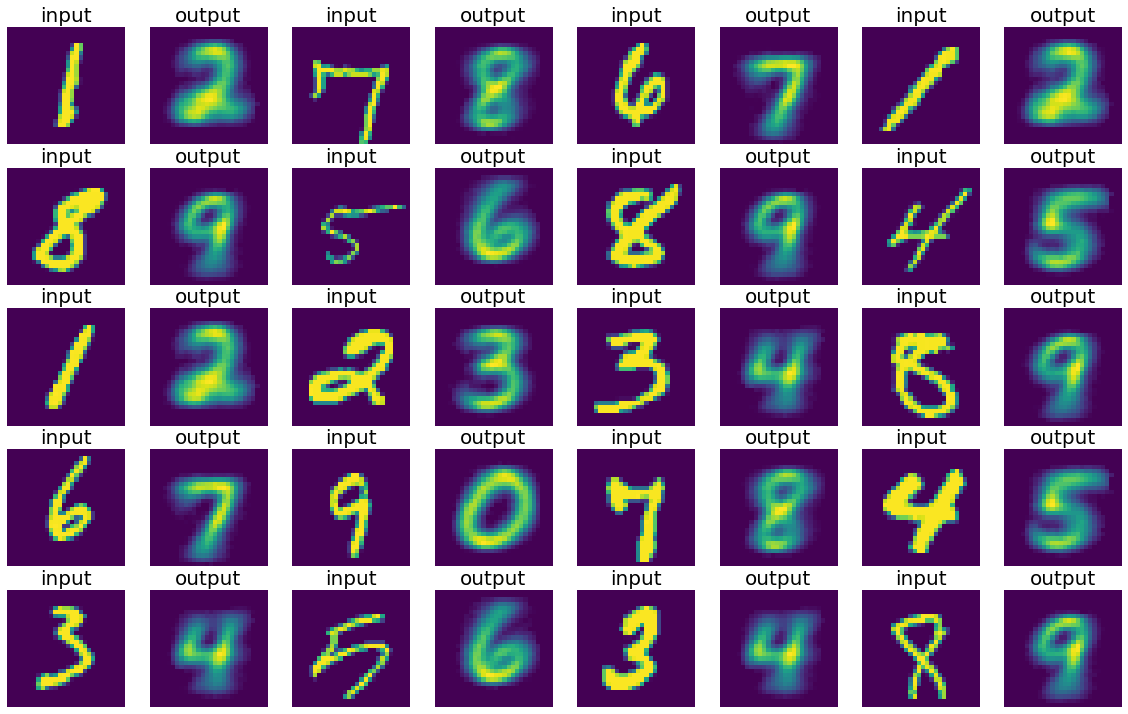

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [3]:
from Helper_codes.ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [4]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from Helper_codes.ae_helper import init_mnist_subset_directories
import random

torch.manual_seed(300)

In [5]:
#### IMPLEMENT YOUR MODEL ####
class FConnedtedAEModel(nn.Module):
    def __init__(self, in_features: int, min_classes: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(), 
            nn.Dropout(p=0.05),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, min_classes)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(min_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Dropout(p=0.05),
            nn.Tanh(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.Dropout(p=0.15),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, in_features),
        )
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [6]:
class FConvAEModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), # 8 14 14
            nn.BatchNorm2d(8), 
            nn.ReLU(),
            nn.MaxPool2d(2), # 8 7 7
            nn.Dropout2d(p=0.1),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), # 16 4 4
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32 2 2
            nn.Tanh()
        )
                              
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2), # 16 5 5
            nn.Tanh(),
            nn.BatchNorm2d(16), 
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), # 8 15 15
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.BatchNorm2d(8), 
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), # 1 28 28
            nn.ReLU()
        )
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [7]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [8]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=128,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=256,
    shuffle=False
)

test_dataloader = DataLoader(
    MnistNextDigitDataset(X_test, Y_test, y_test),
    batch_size=256,
    shuffle=False
)

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
fully_connected_model = FConnedtedAEModel(784,10).to(device)
fully_connected_model

FConnedtedAEModel(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.15, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Tanh()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): Dropout(p=0.15, inplace=F

In [11]:
fully_conv_model = FConvAEModel().to(device)
fully_conv_model

FConvAEModel(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): Tanh()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): Tanh()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (4): ReLU()
    (5): Dropout2d(p=0.1, inplace=False)
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1

In [12]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
# fully_connected
fully_connected_learning_rate = 1e-3
fully_connected_criterion = nn.MSELoss()
fully_connected_optimizer = torch.optim.Adam(fully_connected_model.parameters(), lr=fully_connected_learning_rate)

In [13]:
# fully_conv
fully_conv_learning_rate = 3e-3
fully_conv_criterion = nn.MSELoss()
fully_conv_optimizer = torch.optim.Adam(fully_conv_model.parameters(), lr=fully_conv_learning_rate)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [14]:
import tqdm
from time import time

In [15]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####
def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False):
    eval_loss = 0
    output_samples = []

    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (img_batch, outputs, labels) in pbar:
            img_batch = img_batch.to(device)
            labels = labels.to(device)
            outputs = outputs.to(device)
            if isinstance(model, FConnedtedAEModel):
                img_batch = img_batch.view(img_batch.shape[0], -1)
                outputs = outputs.view(outputs.shape[0], -1)
            elif isinstance(model, FConvAEModel):
                img_batch = img_batch.unsqueeze(1)
                outputs = outputs.unsqueeze(1)
            
            with torch.no_grad():
                predicted = model(img_batch)
            loss = criterion(predicted, outputs)          
            eval_loss += loss.item() * dataloader.batch_size
            
            pbar.set_description(f'Validation Loss: {eval_loss / (i + 1):.3e}')
            
            if test_mode:
                for img, pred, lbl in zip(img_batch, outputs, labels):
                    output_samples.append((img, pred, lbl))
 
    return eval_loss, output_samples

In [16]:
def train_epoch(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, train_loader: torch.utils.data.DataLoader):
    train_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (img_batch, outputs, label) in pbar:
            img_batch = img_batch.to(device)
            label = label.to(device)
            outputs = outputs.to(device)
            if isinstance(model, FConnedtedAEModel):
                img_batch = img_batch.view(img_batch.shape[0], -1)
                outputs = outputs.view(outputs.shape[0], -1)
            elif isinstance(model, FConvAEModel):
                img_batch = img_batch.unsqueeze(1)
                outputs = outputs.unsqueeze(1)
            
            predicted = model(img_batch)
            loss = criterion(predicted, outputs)          
            train_loss += loss.item() * train_loader.batch_size
            
            pbar.set_description(f'Train Loss: {train_loss / (i + 1):.3e}')
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()  
    return train_loss

In [17]:
def train(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, model_path='AETrainedModel.pth', num_epochs=20):
    train_loss_arr, val_loss_arr = [], []
    best_val_loss = None
    best_model_dict = None
    for epoch in range(num_epochs):
        start_time = time()

        train_loss, val_loss = 0, 0

        model.train()  
        train_loss = train_epoch(model, criterion, optimizer, train_dataloader)

        model.eval() 
        val_loss, _ = eval_epoch(model, criterion, val_dataloader)

        train_loss /= len(train_dataloader.dataset)
        val_loss /= len(val_dataloader.dataset)
        train_loss_arr.append(train_loss)
        val_loss_arr.append(val_loss)

        if best_val_loss is None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_dict = model.state_dict()

        end_time = time()

        print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')

        print(f"[Epoch {epoch + 1}]\t"
            f"Train Loss: {train_loss:.9f}\t"
            f"Validation Loss: {val_loss:.9f}")

    print(f"best validation loss is: {best_val_loss:.9f}")
    torch.save(best_model_dict, model_path)
    print(f"best trained model save in {model_path}")
    
    ls_epoch = [_ + 1 for _ in range(num_epochs)]
    plt.plot(ls_epoch, train_loss_arr, color='r', label='Train')
    plt.plot(ls_epoch, val_loss_arr, color='g', label='Validation')
    plt.title(f'Loss plot for model {type(model).__name__}')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show() 

Validation Loss: 1.497e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 167.11it/s]


Epoch 1 finished in 3.45s
[Epoch 1]	Train Loss: 0.092705935	Validation Loss: 0.058809212


Validation Loss: 1.434e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 179.34it/s]


Epoch 2 finished in 3.54s
[Epoch 2]	Train Loss: 0.059214211	Validation Loss: 0.056350358


Validation Loss: 1.424e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 173.69it/s]


Epoch 3 finished in 3.51s
[Epoch 3]	Train Loss: 0.057137564	Validation Loss: 0.055945782


Validation Loss: 1.421e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 175.07it/s]


Epoch 4 finished in 3.58s
[Epoch 4]	Train Loss: 0.056567160	Validation Loss: 0.055825371


Validation Loss: 1.414e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 164.62it/s]


Epoch 5 finished in 3.56s
[Epoch 5]	Train Loss: 0.056261402	Validation Loss: 0.055567373


Validation Loss: 1.419e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 163.40it/s]


Epoch 6 finished in 3.65s
[Epoch 6]	Train Loss: 0.056050424	Validation Loss: 0.055733549


Validation Loss: 1.413e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 157.56it/s]


Epoch 7 finished in 3.58s
[Epoch 7]	Train Loss: 0.055922311	Validation Loss: 0.055513407


Validation Loss: 1.414e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 164.62it/s]


Epoch 8 finished in 3.62s
[Epoch 8]	Train Loss: 0.055774893	Validation Loss: 0.055532343


Validation Loss: 1.409e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 168.39it/s]


Epoch 9 finished in 3.65s
[Epoch 9]	Train Loss: 0.055625693	Validation Loss: 0.055352734


Validation Loss: 1.409e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 173.69it/s]


Epoch 10 finished in 3.65s
[Epoch 10]	Train Loss: 0.055545615	Validation Loss: 0.055363513


Validation Loss: 1.409e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 155.34it/s]


Epoch 11 finished in 3.77s
[Epoch 11]	Train Loss: 0.055383951	Validation Loss: 0.055347164


Validation Loss: 1.406e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 137.87it/s]


Epoch 12 finished in 4.09s
[Epoch 12]	Train Loss: 0.055287394	Validation Loss: 0.055235226


Validation Loss: 1.402e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.71it/s]


Epoch 13 finished in 4.33s
[Epoch 13]	Train Loss: 0.055157866	Validation Loss: 0.055088591


Validation Loss: 1.401e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.51it/s]


Epoch 14 finished in 4.41s
[Epoch 14]	Train Loss: 0.055105845	Validation Loss: 0.055056287


Validation Loss: 1.400e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.60it/s]


Epoch 15 finished in 4.42s
[Epoch 15]	Train Loss: 0.055038586	Validation Loss: 0.054983791


Validation Loss: 1.399e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.89it/s]


Epoch 16 finished in 4.68s
[Epoch 16]	Train Loss: 0.054932925	Validation Loss: 0.054951398


Validation Loss: 1.400e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 94.27it/s]


Epoch 17 finished in 4.87s
[Epoch 17]	Train Loss: 0.054883473	Validation Loss: 0.054989652


Validation Loss: 1.398e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.71it/s]


Epoch 18 finished in 4.88s
[Epoch 18]	Train Loss: 0.054842119	Validation Loss: 0.054933108


Validation Loss: 1.399e+01: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.89it/s]


Epoch 19 finished in 4.92s
[Epoch 19]	Train Loss: 0.054822044	Validation Loss: 0.054976564


Validation Loss: 1.398e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 96.24it/s]


Epoch 20 finished in 5.10s
[Epoch 20]	Train Loss: 0.054785409	Validation Loss: 0.054922424
best validation loss is: 0.054922424
best trained model save in fully_connected_trained_model.pth


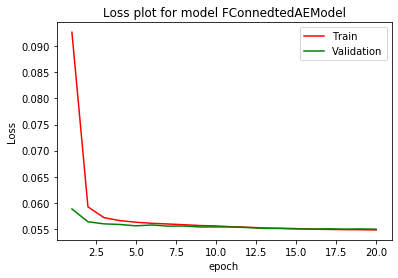

In [18]:
train(fully_connected_model, fully_connected_criterion, fully_connected_optimizer, 'fully_connected_trained_model.pth')

Validation Loss: 1.603e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.91it/s]


Epoch 1 finished in 12.61s
[Epoch 1]	Train Loss: 0.085258838	Validation Loss: 0.062980616


Validation Loss: 1.503e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.98it/s]


Epoch 2 finished in 11.88s
[Epoch 2]	Train Loss: 0.063010167	Validation Loss: 0.059052838


Validation Loss: 1.478e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.91it/s]


Epoch 3 finished in 11.97s
[Epoch 3]	Train Loss: 0.060441134	Validation Loss: 0.058063910


Validation Loss: 1.463e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.95it/s]


Epoch 4 finished in 11.97s
[Epoch 4]	Train Loss: 0.059440621	Validation Loss: 0.057482253


Validation Loss: 1.454e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.23it/s]


Epoch 5 finished in 12.08s
[Epoch 5]	Train Loss: 0.058960127	Validation Loss: 0.057114712


Validation Loss: 1.452e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.12it/s]


Epoch 6 finished in 11.97s
[Epoch 6]	Train Loss: 0.058560809	Validation Loss: 0.057047009


Validation Loss: 1.441e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 44.21it/s]


Epoch 7 finished in 12.15s
[Epoch 7]	Train Loss: 0.058290420	Validation Loss: 0.056621470


Validation Loss: 1.439e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.86it/s]


Epoch 8 finished in 12.08s
[Epoch 8]	Train Loss: 0.058065142	Validation Loss: 0.056517248


Validation Loss: 1.435e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.96it/s]


Epoch 9 finished in 12.26s
[Epoch 9]	Train Loss: 0.057926946	Validation Loss: 0.056361312


Validation Loss: 1.432e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.34it/s]


Epoch 10 finished in 12.10s
[Epoch 10]	Train Loss: 0.057677921	Validation Loss: 0.056237867


Validation Loss: 1.432e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.95it/s]


Epoch 11 finished in 12.19s
[Epoch 11]	Train Loss: 0.057499184	Validation Loss: 0.056275727


Validation Loss: 1.429e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.54it/s]


Epoch 12 finished in 12.04s
[Epoch 12]	Train Loss: 0.057405071	Validation Loss: 0.056139799


Validation Loss: 1.426e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.02it/s]


Epoch 13 finished in 12.35s
[Epoch 13]	Train Loss: 0.057323305	Validation Loss: 0.056023492


Validation Loss: 1.426e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.96it/s]


Epoch 14 finished in 12.96s
[Epoch 14]	Train Loss: 0.057254145	Validation Loss: 0.056013593


Validation Loss: 1.423e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 40.25it/s]


Epoch 15 finished in 12.51s
[Epoch 15]	Train Loss: 0.057163400	Validation Loss: 0.055899178


Validation Loss: 1.425e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.67it/s]


Epoch 16 finished in 12.47s
[Epoch 16]	Train Loss: 0.057137084	Validation Loss: 0.055973872


Validation Loss: 1.431e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.34it/s]


Epoch 17 finished in 12.32s
[Epoch 17]	Train Loss: 0.057132799	Validation Loss: 0.056229256


Validation Loss: 1.423e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.83it/s]


Epoch 18 finished in 12.47s
[Epoch 18]	Train Loss: 0.057070164	Validation Loss: 0.055914665


Validation Loss: 1.423e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.15it/s]


Epoch 19 finished in 12.45s
[Epoch 19]	Train Loss: 0.057061259	Validation Loss: 0.055897941


Validation Loss: 1.424e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.42it/s]


Epoch 20 finished in 12.33s
[Epoch 20]	Train Loss: 0.056953595	Validation Loss: 0.055950668


Validation Loss: 1.421e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 41.46it/s]


Epoch 21 finished in 12.39s
[Epoch 21]	Train Loss: 0.056991742	Validation Loss: 0.055810626


Validation Loss: 1.421e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.35it/s]


Epoch 22 finished in 12.37s
[Epoch 22]	Train Loss: 0.056892090	Validation Loss: 0.055811570


Validation Loss: 1.419e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.86it/s]


Epoch 23 finished in 12.32s
[Epoch 23]	Train Loss: 0.056876764	Validation Loss: 0.055738927


Validation Loss: 1.421e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.39it/s]


Epoch 24 finished in 12.40s
[Epoch 24]	Train Loss: 0.056862363	Validation Loss: 0.055823372


Validation Loss: 1.418e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 44.56it/s]


Epoch 25 finished in 12.29s
[Epoch 25]	Train Loss: 0.056841408	Validation Loss: 0.055713533


Validation Loss: 1.417e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.06it/s]


Epoch 26 finished in 12.41s
[Epoch 26]	Train Loss: 0.056815492	Validation Loss: 0.055664255


Validation Loss: 1.418e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.06it/s]


Epoch 27 finished in 12.66s
[Epoch 27]	Train Loss: 0.056792621	Validation Loss: 0.055712430


Validation Loss: 1.417e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.13it/s]


Epoch 28 finished in 12.36s
[Epoch 28]	Train Loss: 0.056764465	Validation Loss: 0.055669964


Validation Loss: 1.420e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.05it/s]


Epoch 29 finished in 12.37s
[Epoch 29]	Train Loss: 0.056701576	Validation Loss: 0.055792072


Validation Loss: 1.416e+01: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.77it/s]


Epoch 30 finished in 12.52s
[Epoch 30]	Train Loss: 0.056691243	Validation Loss: 0.055641398
best validation loss is: 0.055641398
best trained model save in fully_conv_trained_model.pth


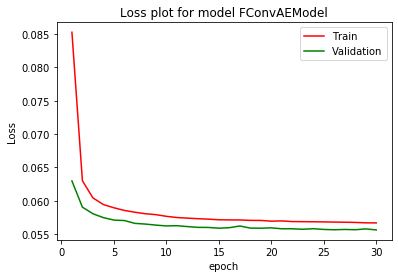

In [19]:
train(fully_conv_model, fully_conv_criterion, fully_conv_optimizer, 'fully_conv_trained_model.pth', 30)

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [20]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
def test_model(model: nn.Module, criterion: nn.Module, test_dataloader: torch.utils.data.DataLoader, model_path='AETrainedModel.pth'):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_loss , samples = eval_epoch(model, criterion, test_dataloader, True)
    test_loss /= len(test_dataloader.dataset)
    print(f" Test Loss for model {type(model).__name__}: {test_loss:.9f}")
    return samples

In [21]:
fully_connected_samples = test_model(fully_connected_model, fully_connected_criterion, test_dataloader, 'fully_connected_trained_model.pth')

Validation Loss: 1.395e+01: 100%|██████████████████████████████████████████████████████| 55/55 [00:00<00:00, 97.95it/s]


 Test Loss for model FConnedtedAEModel: 0.054814162


In [22]:
fully_conv_samples = test_model(fully_conv_model, fully_conv_criterion, test_dataloader, 'fully_conv_trained_model.pth')

Validation Loss: 1.411e+01: 100%|██████████████████████████████████████████████████████| 55/55 [00:01<00:00, 45.46it/s]


 Test Loss for model FConvAEModel: 0.055449048


## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

In [23]:
#### VISUALIZE YOUR MODEL ####
def visualize_model(samples):
    fig, axs = plt.subplots(10, 8, figsize=(40, 40), tight_layout=True)
    for i, idx in enumerate(torch.randint(0, len(samples), [40])):
        img, pred, lbl = samples[idx]
        i1 = i * 2
        i2 = (i * 2) + 1 
        axs[int(i1 / 8), i1 % 8].imshow(img.view(28,28))
        axs[int(i2 / 8), i2 % 8].imshow(pred.view(28,28))
        axs[int(i1 / 8), i1 % 8].set_title(f'input number is {lbl}',fontsize=24)
        axs[int(i2 / 8), i2 % 8].set_title('output',fontsize=24)

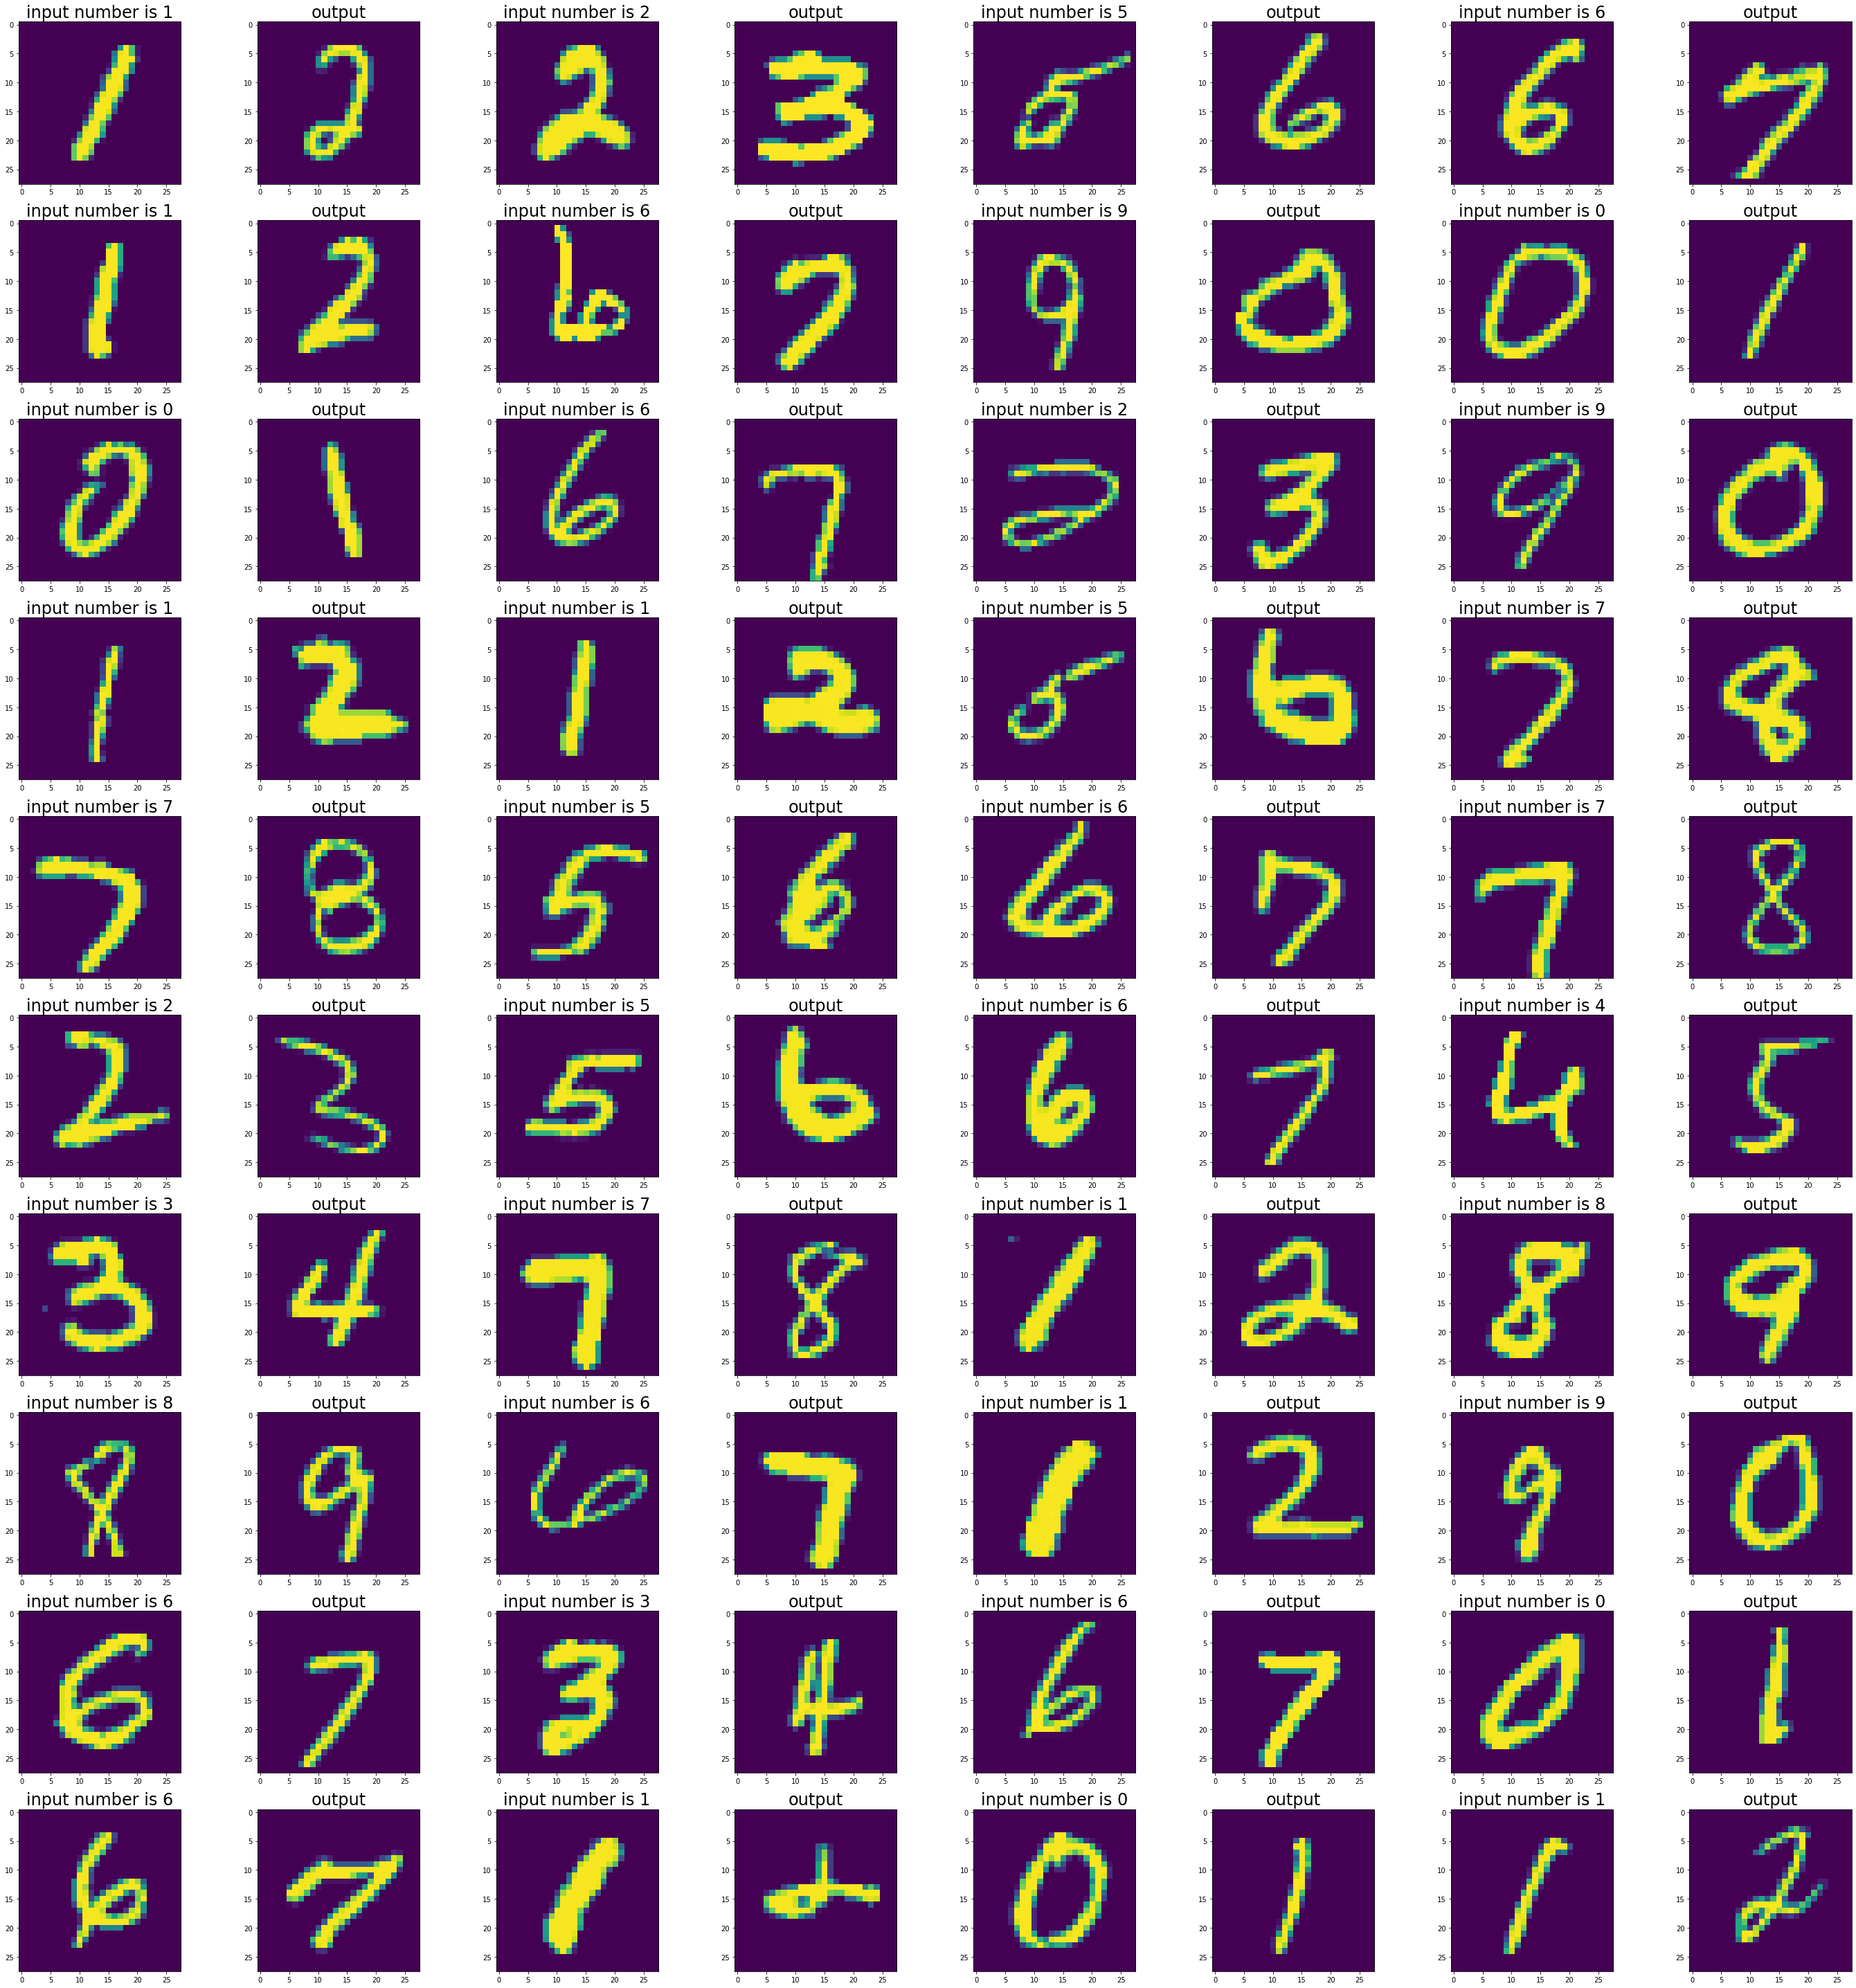

In [31]:
visualize_model(fully_connected_samples)

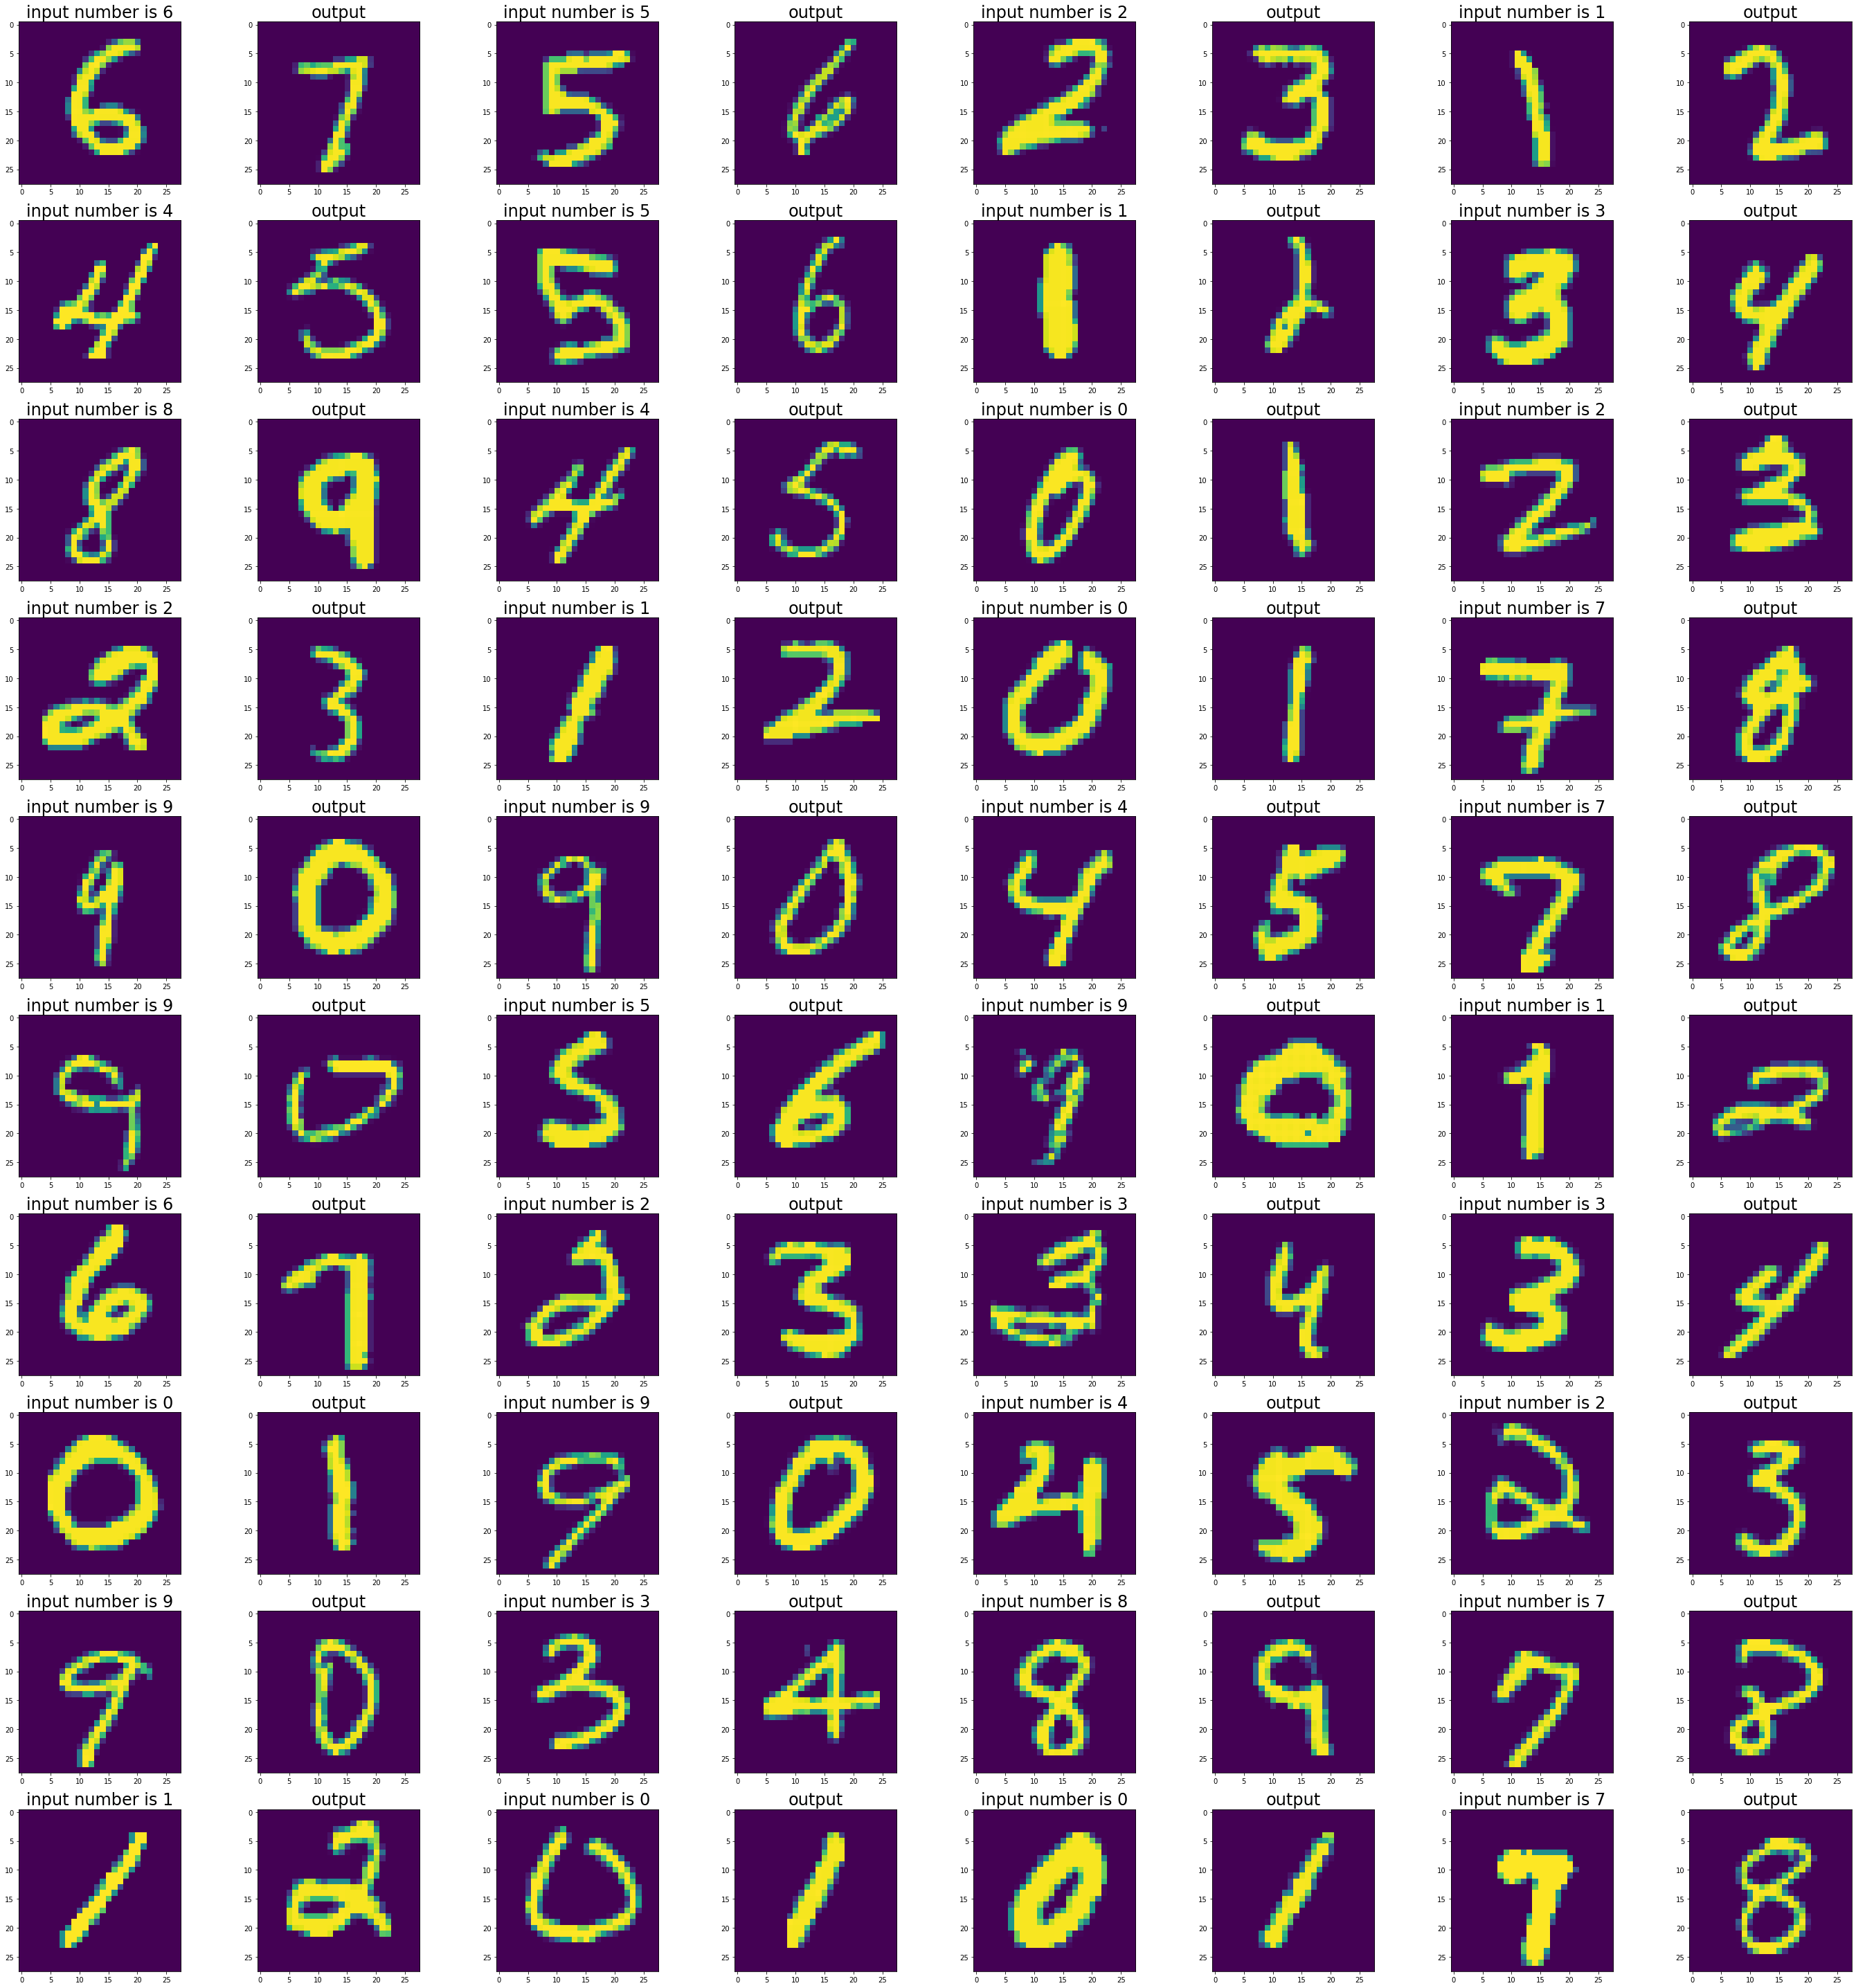

In [30]:
visualize_model(fully_conv_samples)